# Analiza i predykcja spłaty należności przez posiadaczy kart kredytowych.

<a class="anchor" id="toc"></a>
## Spis treści

1. [Wstęp](#wstep)

2. [Ocena modelu i wybór optymalnego punktu odcięcia - założenia biznesowe](#zalozenia)
    
3. [Opis zbioru danych](#zbior)

4. [Import bibliotek](#biblioteki)

5. [Wczytanie danych](#wczytanie)

6. [Wstępna analiza i formatowanie danych](#format)

7. [Analiza zbioru danych](#analiza)
    1. [Atrybuty numeryczne](#a_num)
    2. [Atrybuty kategoryzujące](#a_kat)
    3. [Zmienna objaśniana](#z_celu)

8. [Analiza zależności](#a_zal)
    1. [Atrybuty numeryczne i kategoryzujące porządkowe a zmienna objaśniana](#num_celu)
    2. [Atrybuty kategoryzujące nominalne a zmienna objaśniana](#kat_celu)
             
9. [Dodatkowe analizy](#dodatkowe)

10. [Przygotowanie danych do modelowania](#przygotowanie)
    1. [Kodowanie "gorącojedynkowe" atrybutów kategoryzujących nominalnych](#kodowanie)
    2. [Podział zbioru na uczący i testowy](#podzial)
    3. [Dobór atrybutów](#dobor)

11. [Model](#model)
    1. [Budowa modelu](#budowa)
    2. [Ocena modelu dla zbioru walidacyjnego](#ocena)

12. [Finalna weryfikacja jakości modelu](#model_fin)

    1. [Model finalny](#budowa_fin)
    2. [Ocena modelu dla zbioru testowego](#ocena_fin)
    3. [Wyznaczanie optymalnego punktu odcięcia](#punkt)
    4. [Ocena modelu z uwzględnieniem optymalnego punktu odcięcia](#ocena_punkt)
    5. [Podsumowanie wyników i wyznaczenie rentowności](#rentownosc)
    
13. [Podsumowanie i wnioski](#podsumowanie) 

<a class="anchor" id="wstep"></a>
## Wstęp
Posiadacze kart kredytowych są klientami dużego bank komercyjnego w Tajwanie działającego na rynku kredytów w tym m.in. wydającego karty kredytowe dla swoich klientów. Zadanie polega na optymalizacji dochodów banku od obecnych klientów, którzy posiadają kartę kredytową. Firma dysponuje bazą 30 000 klientów.
Celem projektu jest wykonanie modelu predykcyjnego, który pozwoli wyznaczyć wystąpienie niewypłacalności klienta.
Na podstawie analizy danych klientów banku zostanie wykonana predykcja prawdopodobieństwa niespłacenia zobowiązania w przyszłym miesiącu.
Na podstawie uwarunkowań biznesowych zostanie wybrany poziom prawdopodobieństwa (punkt odcięcia), dla którego klient zostanie sklasyfikowany jako wiarygodny / niewiarygodny. Poziom punktu odcięcia powinien być dobrana tak, aby maksymalizować dochód banku z całego portfela kredytowego.

Wyniki analizy oprócz samej oceny spłaty przez klientów należności w przyszłym miesiącu na obecnej karcie kredytowej mogą być wykorzystane do oceny wniosku o wydanie nowej karty kredytowej oraz wykorzystane do ogólnej oceny wiarygodności klienta np. przy przyznawaniu kredytu konsumpcyjnego lub przy dostosowaniu ofert innych produktów bankowych. 


Z uwagi na wytyczne organów nadzorczych (KNF) w zakresie wykorzystania modeli predykcyjnych przez instytucje finansowe należy wykorzystać model w pełni interpretowalny. Dodatkowo należy ograniczyć transformowanie danych oraz w miarę możliwość (bez utraty skuteczności modelu) ograniczyć ilość atrybutów (wymiarowość) w celu uniknięcia przetrenowaniu modelu.

Do wykonania modelu zostanie wykorzystany algorytm regresji logistycznej. W celu właściwego działania algorytmu atrybuty kategoryzujące nominalne zostaną przetransformowane na wartości liczbowe z zastosowaniem kodowania "gorącojedynkowego". Dodatkowo zostanie wykonany dobór najlepszych atrybutów do modelowania z wykorzystaniem algorytmu lasów losowych. 

<a class="anchor" id="zalozenia"></a>
## Ocena modelu i wybór optymalnego punktu odcięcia - założenia biznesowe
[Powrót do spisu treści](#toc)

Istotnym elementem procesu weryfikacji modelu z punktu widzenia rzeczywistych wyników jest wybór właściwego punktu odcięcia. Jego poziom ma wpływ na ilość klientów sklasyfikowanych jako niewiarygodnych, co przekłada się na dochód banku z całego portfela kredytowego. 

Zbyt duży poziom spowoduje, że tylko nieliczne przypadki, o bardzo dużym poziomie prawdopodobieństwa będą klasyfikowane jako pozytywne. Może to spowodować zwiększenie ilości klientów błędnie sklasyfikowanych jako wiarygodnych (FN) i poważne straty banku. Odwrotnie, zbyt mała wartość spowoduje, że większość przypadków, o małym poziomie prawdopodobieństwa będzie klasyfikowanych jako pozytywne. W wyniku tego duża ilości klientów będzie błędnie sklasyfikowanych jako niewiarygodnych (FP) i bank straci potencjalny zysk który uzyskałby z wiarygodnych klientów.

W celu wyboru punktu prawdopodobieństwo przynależności obserwacji do danej klasy tzw. punktu odcięcia zostaną wzięte pod uwagę zyski i straty banku spowodowane podjęciem określonej decyzji przy przyznawaniu karty kredytowej.

Podczas procesu wydawania karty kredytowej pracownik banku może podjąć decyzje o przyznaniu lub odmowie przyznania karty kredytowej osobie wnioskującej.
Za przypadek pozytywny uznajemy zdarzenie niespłacenia zobowiązania przez klienta banku {1}, a brak zdarzenia niespłacenia za zdarzenie negatywne {0}.
W wyniku podjęcia określonej decyzji mogą wystąpić następujące sytuacje:
* True Negative: przyznanie karty kredytowej i spłacanie zadłużenia
* False Negative: przyznanie karty kredytowej i niespłacanie zadłużenia
* True Positive: nieprzyznanie karty kredytowej i niespłacanie zadłużenia
* False Positive: nieprzyznanie karty kredytowej i spłacanie zadłużenia

Zatem sytuacja True Negative to oczekiwany wiarygodny klient, a False Negative to klient spośród tych oczekiwanych, który faktycznie przyniósł szkodę firmie. 

Podjęcie określonej decyzji ma wpływ na zysk bądź stratę banku. Dla uproszczenia zapisu i analizy porównawczej dochodów uzyskiwanych przez model założono, że zysk i strata banku dla pojedynczego klienta będą mieściły się w zakresie [0, 100]. Czyli bank może maksymalnie zarobić 100% i stracić 100%, przy czym 100% oznacza uśrednioną wartość udzielonego kredytu.
Na podstawie powyższych danych przyjęto następujące założenia dla poszczególnych decyzji:
* True Negative: bank zarobi 15 (zysk z udzielenia kredytu i prowizja od sprzedaży kredytu), 
* False Negative: bank straci 50 (średnia strata) (założono, że bank częściowo odzyska pożyczoną kwotę i zarobi prowizje od sprzedaży kredytu),
* True Positive: bank nie zarabia ani nie traci (nie będzie brane pod uwagę),
* False Positive: bank nie zarabia ani nie traci (nie będzie brane pod uwagę, założono nieuwzględnianie utraconych korzyści z powodu nie przyznania karty klientowi).

Jako funkcje dochodu, która będzie maksymalizowana przyjęto **dochód = zysk - strata**, gdzie:
* zysk = ilość wiarygodnych klientów (TN) * 15
* strata = ilość niewiarygodnych klientów (FN) * 50 

Więc ostatecznie otrzymano:

**dochód = TN * 15 - FN * 50 -> max**

Dzięki temu w łatwy sposób można wyznaczyć średnią rentowność całego procesu udzielania kredytu, jako średni dochód przypadający na łączną ilość udzielonych kredytów, zgodnie z poniższym wzorem. Następnie porównywać rentowność różnych modeli bez potrzeby uwzględniania konkretnych wartości zależnych od koniunktury i polityki banku.

**rentowność =  dochód / ilość udzielonych kredytów**                                                                                 

Z powodu uproszczenia analizy porównawczej dochodów uzyskiwanych przez model oraz braku dokładnej wiedzy o rzeczywistych kosztach i zyskach prowadzenia działalności kredytowej zastosowano uproszczenie w kalkulacji dochodu. Przyjęte założenia nie uwzględniają kilku czynników, które mogą mieć wpływ na rzeczywisty wynik. Dodatkowo do końcowego wyniku należałoby uwzględnić m.in. zmienne koszty obsługi i przyznawania kredytu, wpływ nieudzielenia karty kredytowej osobie spłacającej. Również założenie, że bank nie odzyska 50% wartości kredytu może nie być właściwe. Na jego poziom mogą mieć wpływ koszty i skuteczność windykacji klientów. Ponadto zdarzenia losowe o dużym wpływie na wyniki udzielania kredytów (np. recesja) mogą znacząco zmienić rzeczywisty wynik.


<a class="anchor" id="zbior"></a>
## Opis zbioru danych
[Powrót do spisu treści](#toc)

W projekcie zostały użyte dane pochodzące ze strony https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

Autorem danych jest I-Cheng Yeh z Department of Information Management, Chung Hua University, Taiwan.  
Dane dotyczą zaległości w spłatach przez klientów banku na Tajwanie. 

Opis zbioru danych:
 - Ilość obserwacji: 30000
 - Typy atrybutów: liczby zmiennoprzecinkowe (Real), liczby całkowite (Integer)
 - Ilość atrybutów: 24
 - Data dodania: 26.01.2016
 - Braki w danych: Brak
 
Opis atrybutów:
 - Y: Zmienna objaśniana określająca zdarzenie pozytywne - brak spłaty zobowiązania w kolejnym miesiącu (październiku 2005) (1=Tak, 0=Nie),
 - X1: Limit przyznanego kredytu w TWD (dolar tajwański)  (uwzględnia daną osobę i jej najbliższą rodzinę),
 - X2: Płeć (1 = mężczyzna; 2 = kobieta),
 - X3: Wykształcenie (1 = wyższe pełne (graduate school); 2 = wyższe; 3 = średnie; 4 = inne),
 - X4: Stan cywilny (1 = zamężna/żonaty; 2 = wolny; 3 = inny),
 - X5: Wiek (w latach),
 - X6 - X11: Historia poprzednich spłat od kwietnia 2005 do września 2005, podana w następujący sposób: X6 = stan spłaty we wrześniu 2005 ... X11 = stan spłaty w kwietniu 2005 (-1 = płatność w terminie; 1 = opóźnienie o 1 miesiąc; 2 = opóźnienie o 2 miesiące; ... ; 9 = opóźnienie o 9 miesięcy lub więcej). Dodatkowo występują wartości -2 i 0, których interpretacja podana jest jako: -2 i 0 = nie ma żadnego salda płatności.
 - X12-X17: Wartość na wyciągu w TWD (X12 = wyciąg za wrzesień 2005; X13 = wyciąg za sierpień 2005; ... ; X17 = wyciąg za kwiecień 2005),
 - X18-X23: Wartość poprzednich płatności (X18 = suma płatności we wrześniu 2005, X19 = suma płatności w sierpniu 2005; ... ; X23 = suma płatności w kwietniu 2005).



Z powodu braku informacji podanych w opisie zbioru danych zostało przyjęte założenie, że zdarzenie pozytywne będzie przewidywane dla października 2005, ponieważ ostatnie dane pochodzą z września 2005. Dodatkowo w opisie zbioru danych nie ma informacji o warunkach zajścia zdarzenia niewywiązania się ze spłaty.

Należy również zwrócić uwagę, że dysponujemy danymi klientów którzy są już klientami banku i mają określoną historię spłat kredytu i przy ewentualnej analizie nowego zbioru danych należy wziąć to pod uwagę.


<a class="anchor" id="biblioteki"></a>
## Import bibliotek
[Powrót do spisu treści](#toc)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm_api
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<a class="anchor" id="wczytanie"></a>
## Wczytanie danych
[Powrót do spisu treści](#toc)

In [2]:
plik = pd.ExcelFile('default_of_credit_card_clients.xls') #wczytanie pliku .xls
df = plik.parse('Data') #zamiana tabeli excel na ramkę danych
df #oryginalne dane

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [3]:
#wczytanie jeszcze raz danych ze zmianą nazw kolumn na polskie żeby łatwiej było je analizować i usunięcie 1 wiersza
df = plik.parse('Data', skiprows=1, names = ['id', 'limit_kredytu', 'plec', 'wyksztalcenie', 
                                             'stan_cywilny', 'wiek', 'splata_wrz', 'splata_sie',
                                             'splata_lip', 'splata_cze', 'splata_maj', 
                                             'splata_kwi', 'wyciag_wrz', 'wyciag_sie', 
                                             'wyciag_lip', 'wyciag_cze', 'wyciag_maj', 
                                             'wyciag_kwi', 'platnosc_wrz', 'platnosc_sie', 'platnosc_lip', 
                                             'platnosc_cze', 'platnosc_maj', 'platnosc_kwi', 'y']) 
                                            
df.drop('id', axis = 1, inplace = True)     #usunięcie id żeby nie było dwóch kolumn z liczbami porządkowymi
df.head()

,limit_kredytu,plec,wyksztalcenie,stan_cywilny,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,...,wyciag_cze,wyciag_maj,wyciag_kwi,platnosc_wrz,platnosc_sie,platnosc_lip,platnosc_cze,platnosc_maj,platnosc_kwi,y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


<a class="anchor" id="format"></a>
## Wstępna analiza i formatowanie danych
[Powrót do spisu treści](#toc)

Sprawdzenie zgodności zbioru danych z opisem:

In [4]:
print ('Ilość obserwacji:',df.shape[0],'\n')
print('Typy poszczególnych zmiennych:\n',df.dtypes,'\n')
print ('Ilość atrybutów:',df.shape[1],'\n')
print ('Braki w danych:',df.isnull().any().any(),'\n')


Ilość obserwacji: 30000 

Typy poszczególnych zmiennych:
 limit_kredytu    int64
plec             int64
wyksztalcenie    int64
stan_cywilny     int64
wiek             int64
splata_wrz       int64
splata_sie       int64
splata_lip       int64
splata_cze       int64
splata_maj       int64
splata_kwi       int64
wyciag_wrz       int64
wyciag_sie       int64
wyciag_lip       int64
wyciag_cze       int64
wyciag_maj       int64
wyciag_kwi       int64
platnosc_wrz     int64
platnosc_sie     int64
platnosc_lip     int64
platnosc_cze     int64
platnosc_maj     int64
platnosc_kwi     int64
y                int64
dtype: object 

Ilość atrybutów: 24 

Braki w danych: False 



Zmiana wartości atrybutów kategoryzujących nominalnych *wykształcenie*, *stan_cywilny*, *plec* z liczbowych na tekstowe do dalszej analizy.


In [5]:
df.plec.replace([1,2], ['mezczyzna','kobieta'], inplace = True)

df.wyksztalcenie.replace([0, 1, 2, 3, 4, 5, 6], ['nieznane', 'wyzsze_pelne', 'wyzsze', 'srednie', 
                                                 'inne', 'nieznane', 'nieznane'], inplace = True)
df.stan_cywilny.replace([0, 1, 2, 3], ['nieznany', 'w_zwiazku', 'kawaler_panna', 'inny'], inplace = True)

W zbiorze występuje jeszcze atrybut kategoryzujący porządkowy *spłata w poszczególnych miesiącach* (jego wartości występują w ściśle określonym porządku). Dla tego atrybutu do analizy zostaną zachowane wartości liczbowe, bo ich wartości mają znaczenie i wpływają na działanie modelu.

<a class="anchor" id="analiza"></a>
## Analiza zbioru danych
[Powrót do spisu treści](#toc)

<a class="anchor" id="a_num"></a>
### Atrybuty numeryczne 

Ogólne porównanie atrybutów numerycznych i atrybutu kategoryzującego - spłata w poszczególnych miesiącach

In [6]:
df.describe()

,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,wyciag_wrz,wyciag_sie,...,wyciag_cze,wyciag_maj,wyciag_kwi,platnosc_wrz,platnosc_sie,platnosc_lip,platnosc_cze,platnosc_maj,platnosc_kwi,y
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Dla limitu kredytowego odchylenie standardowe jest bardzo duże równe 129748 przy średniej równej 167484.
Średni wiek wynosi 35.5 roku przy odchy. standardowym równym 9.2, ale występują także osoby starsze. Spłaty w większości są w terminie. Średnia wartość wyciągu w  kolejnych miesiącach wzrasta i odchy. standardowe jest znaczne np. dla września wynosi 73636 przy średniej równej 51223 (związane jest to z wielkością limitów kredytowych). Podobnie średnia wartość poprzednich płatności z czasem wzrasta, a odchy. standardowe jest bardzo duże np. dla września wynosi 16563 przy średniej 5664.


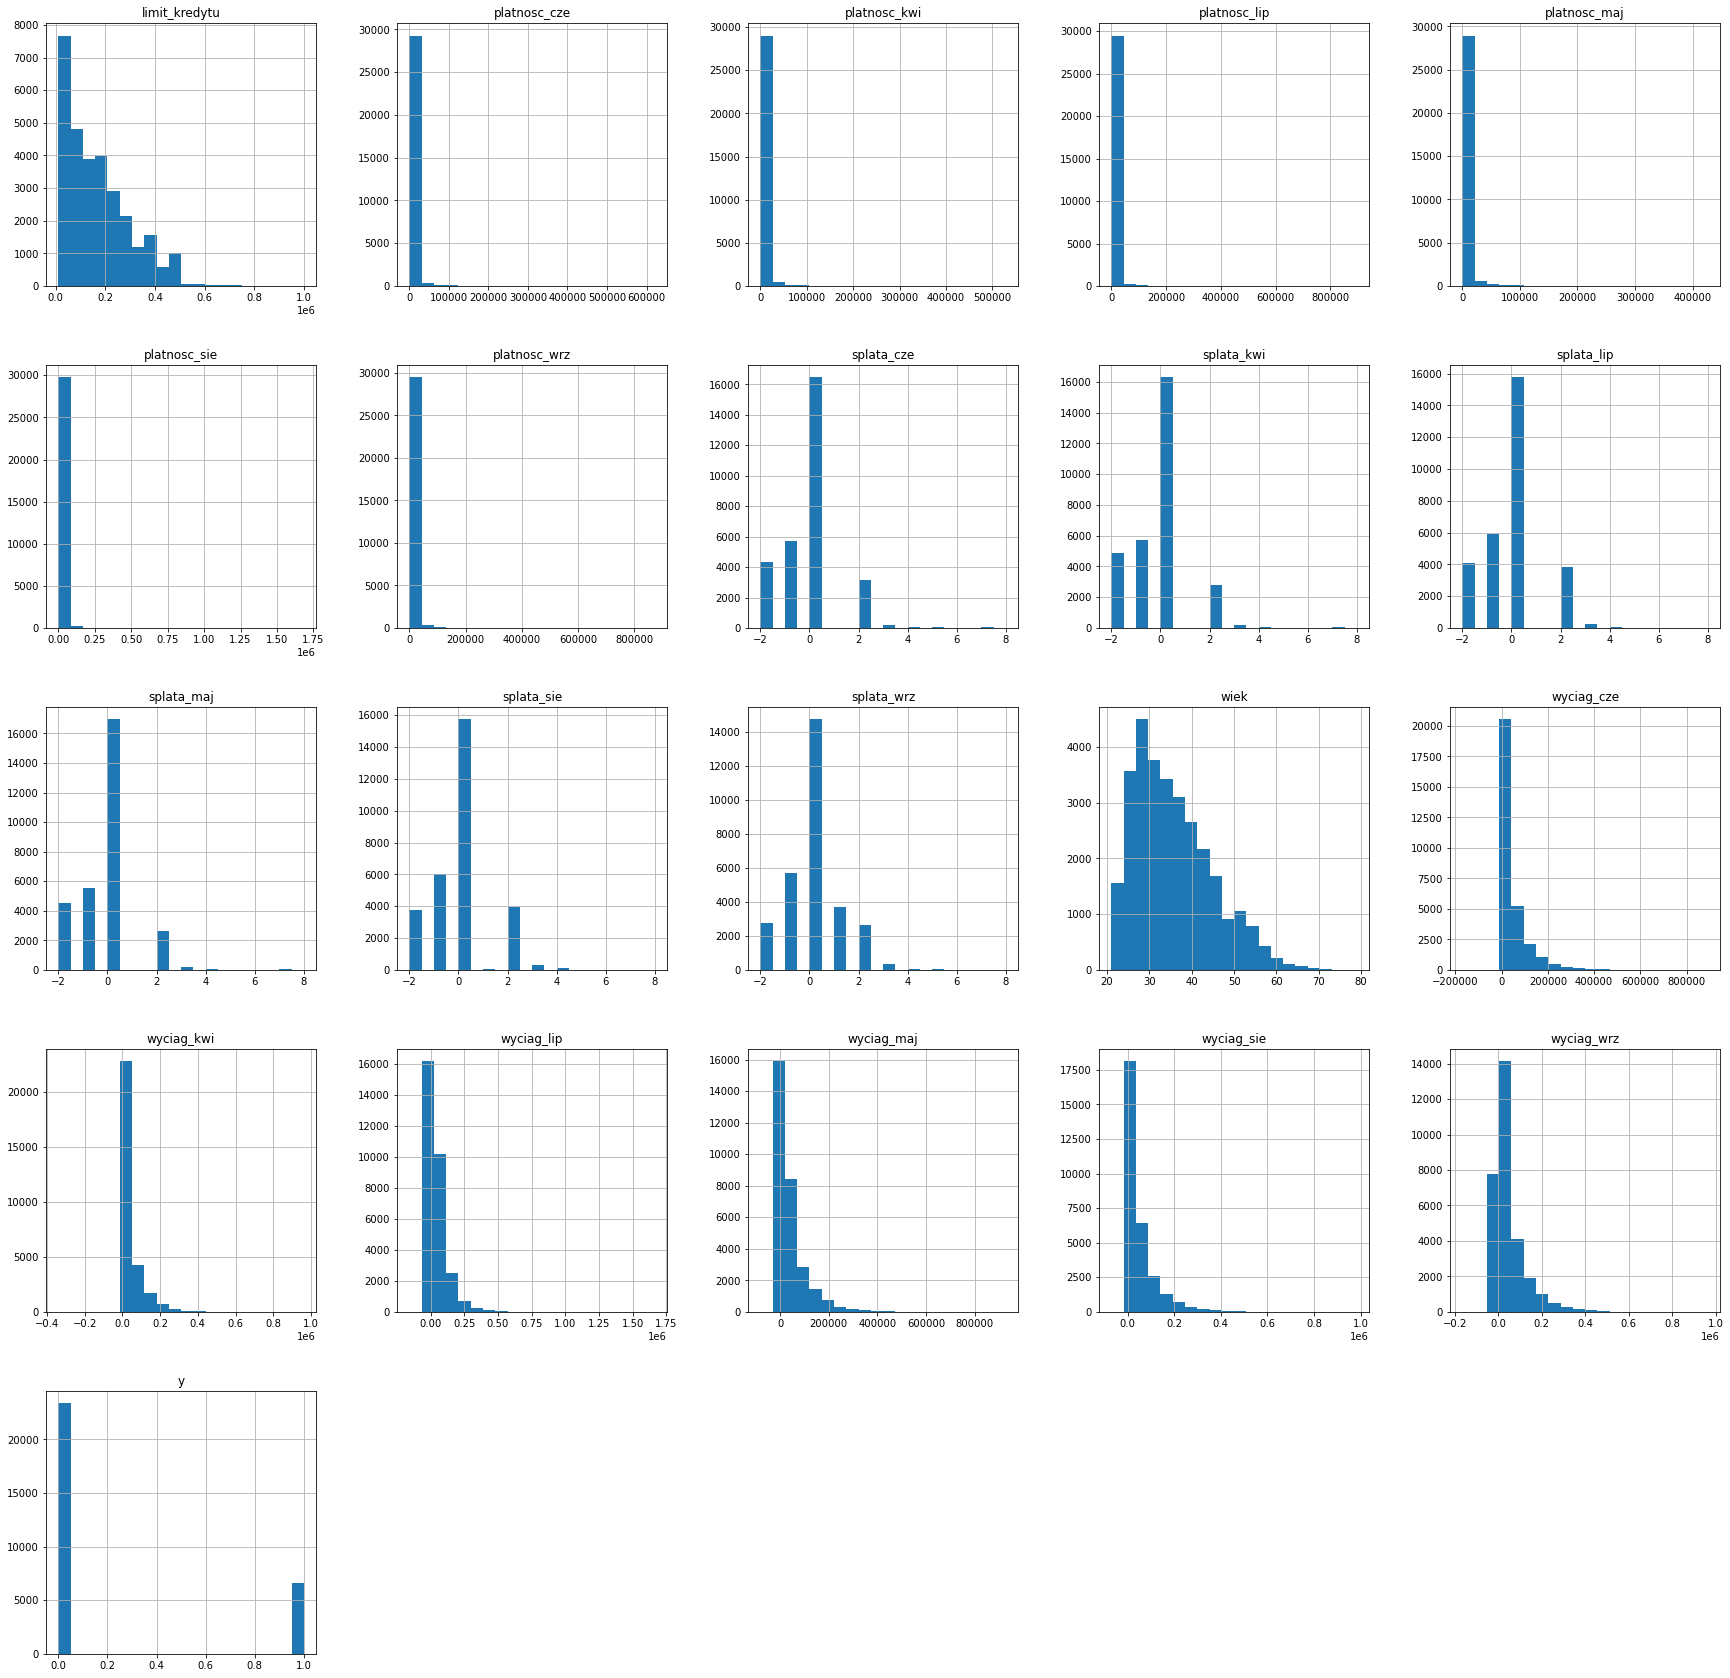

In [7]:
df.hist(figsize=(30,30), bins=20);

#### Analiza odzielnie każdego rodzaju atrybutu numerycznego pod kątem rozkładu wartości i ew. wskazanie wartości odstających.

##### Limit_kredytu

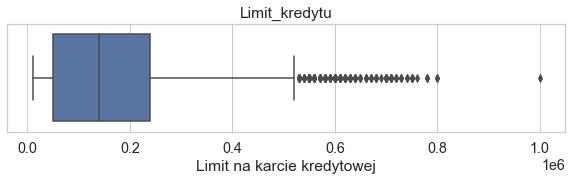

Atrybut nie ma rozkładu normalnego


In [8]:
plt.figure(figsize=(10,2))
sns.set(font_scale=1.3, style="whitegrid")
sns.boxplot(df['limit_kredytu']).set(title = 'Limit_kredytu', xlabel = 'Limit na karcie kredytowej')
plt.show()

if(scipy.stats.normaltest(df['limit_kredytu'])[1] < 0.05): # Test na normalność rozkładu
    print('Atrybut nie ma rozkładu normalnego')
else:
    print('Atrybut ma rozkład normalny')

Rozkład jest prawostronnie skośny. Większość limitów na karcie jest mniejszych niż ok. 250000. Jest kilka wartości odstających w tym jedna wartość jest dużo większa od pozostałych i wynosi 1000000. 

##### wiek

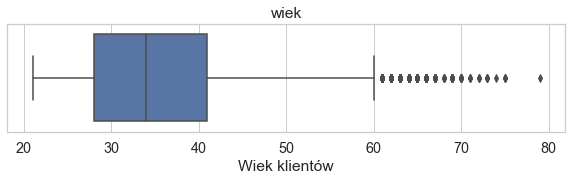

Atrybut nie ma rozkładu normalnego


In [9]:
plt.figure(figsize=(10,2))
sns.set(font_scale=1.3, style="whitegrid")
sns.boxplot(df['wiek']).set(title = 'wiek', xlabel = 'Wiek klientów')
plt.show()

if(scipy.stats.normaltest(df['limit_kredytu'])[1] < 0.05): # Test na normalność rozkładu
    print('Atrybut nie ma rozkładu normalnego')
else:
    print('Atrybut ma rozkład normalny')

Rozkład jest prawostronnie skośny. Większość klientów to osoby w średnim wieku jednak jest też kilka osób w wieku emerytalnym.

##### Wartość na wyciągu (wyciag_kwi - wyciag_wrz)

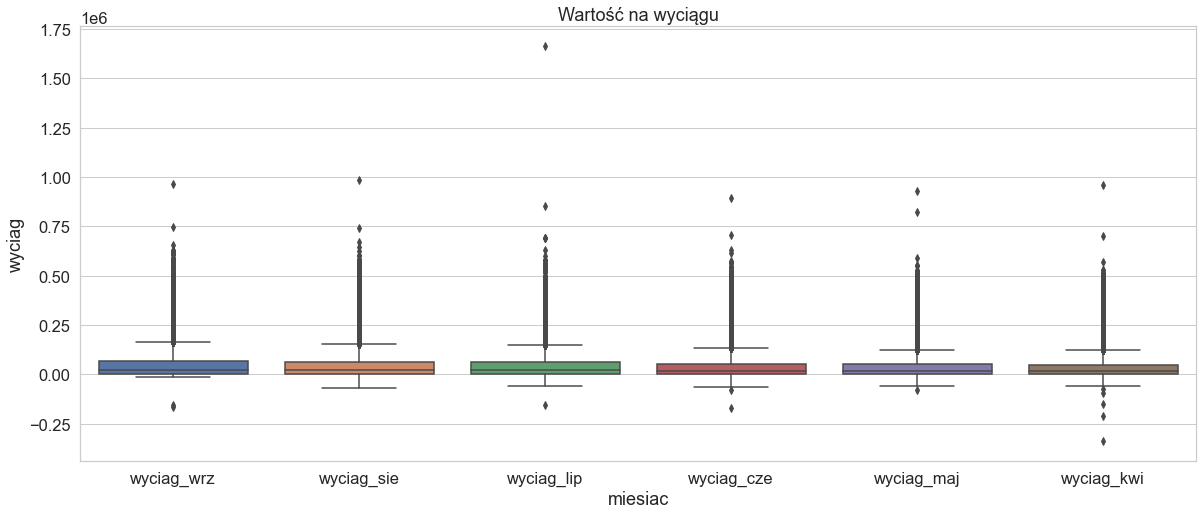

In [10]:
#Wszystkie atrybuty dotyczące wartości na wyciągu
wyciag = pd.melt(df, value_vars=['wyciag_wrz', 'wyciag_sie','wyciag_lip', 'wyciag_cze', 'wyciag_maj', 
                                 'wyciag_kwi'], var_name=['miesiac'], value_name = 'wyciag') 
plt.figure(figsize=(20,8))
sns.set(font_scale=1.5, style="whitegrid")
sns.boxplot(data = wyciag, y = 'wyciag', x = 'miesiac').set(title = 'Wartość na wyciągu')
plt.show()


Rozkłady są prawostronnie skośne i nie mają rozkladu normalnego. Większość wartości na wyciągu jest mniejszych niż ok. 200000, ale są również wartości odstające.

##### Wartość poprzednich płatności  (platnosc_kwi - platnosc_wrz)

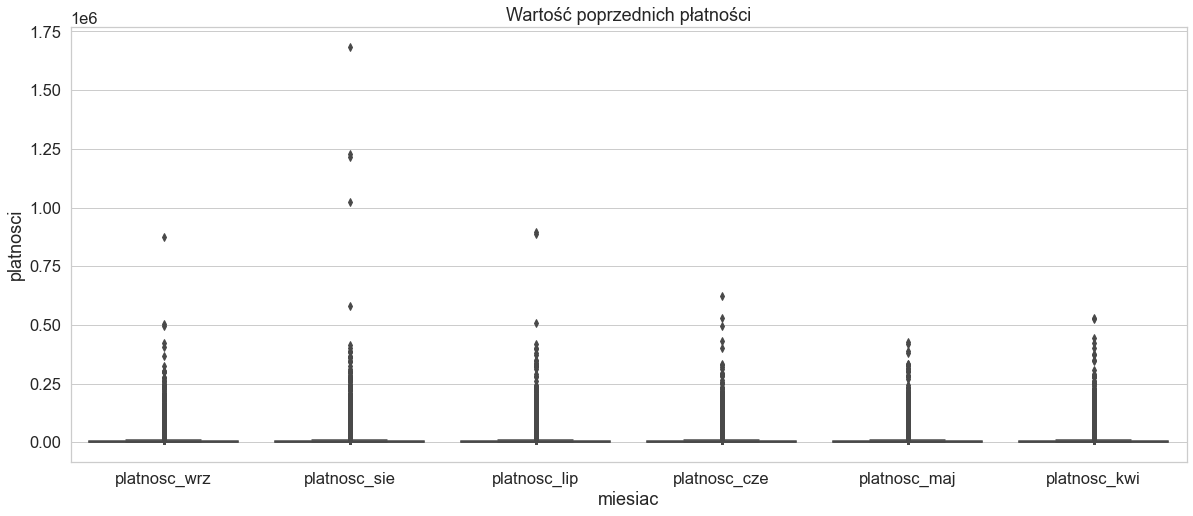

In [11]:
#Wszystkie atrybuty dotyczące wartości poprzednich platnosci
platnosci = pd.melt(df, value_vars=['platnosc_wrz', 'platnosc_sie', 'platnosc_lip', 'platnosc_cze', 'platnosc_maj', 
                                 'platnosc_kwi'], var_name=['miesiac'], value_name = 'platnosci') 
plt.figure(figsize=(20,8))
sns.set(font_scale=1.5, style="whitegrid")
sns.boxplot(data = platnosci, y = 'platnosci', x = 'miesiac').set(title = 'Wartość poprzednich płatności')
plt.show()


Rozkłady są prawostronnie skośne i nie mają rozkladu normalnego. Większość wartości na wyciągu jest mniejszych niż ok. 100000, ale są również wartości odstające.

Podumowując na podstawie powyższej analizy można stwierdzić, że wszystkie atrybuty numeryczne posiadają wartości odstające oraz nie mają rozkładów normalnych (ich rozkłady mają skośności).
Powyższa wnioski zostaną wykorzystane przy doborze dalszych metod analizy.


<a class="anchor" id="a_kat"></a>
### Atrybuty kategoryzujące

### Porządkowe

##### Stan spłaty zadłużenia (splata_kwi - splata_wrz)

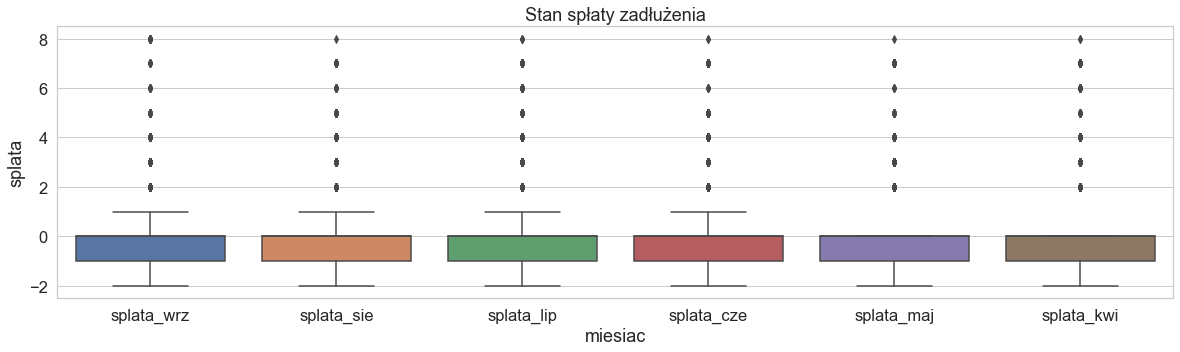

In [12]:
#Wszystkie atrybuty dotyczące stanu spłaty zadłużenia
splata = pd.melt(df, value_vars=['splata_wrz', 'splata_sie','splata_lip', 'splata_cze', 'splata_maj', 
                                    'splata_kwi'], var_name=['miesiac'], value_name = 'splata') 
plt.figure(figsize=(20,5))
sns.set(font_scale=1.5, style="whitegrid")
sns.boxplot(data = splata, y = 'splata', x = 'miesiac').set(title = 'Stan spłaty zadłużenia',)
plt.show()


Większość zadłużenia jest spłacana w terminie (wartość -1). Jednak występują przypadki w których spłata przeciąga się do kilku miesięcy oraz występują przypadki braku salda płatności (wartości -2, 0).

### Nominalne

##### *plec*, *wyksztalcenie*, *stan_cywilny*

In [13]:
#ogólne porównanie
df.select_dtypes(include = ['object']).describe()

,plec,wyksztalcenie,stan_cywilny
count,30000,30000,30000
unique,2,5,4
top,kobieta,wyzsze,kawaler_panna
freq,18112,14030,15964


Z podanego zestawienia wynika, że najwięcej wśród klientów jest kobiet, większość klientów to osoby z wyższym wykształceniem (prawie połowa) oraz najwięcej osób posiada stan cywilny kawaler lub panna.

##### plec

In [14]:
print(df['plec'].value_counts(normalize = True))

kobieta      0.603733
mezczyzna    0.396267
Name: plec, dtype: float64


W większości klientami są kobiety i stanowią ok. 60%.

##### wykształcenie

In [15]:
print(df['wyksztalcenie'].value_counts(normalize = True))

wyzsze          0.467667
wyzsze_pelne    0.352833
srednie         0.163900
nieznane        0.011500
inne            0.004100
Name: wyksztalcenie, dtype: float64


W znacznej większości klientami są osoby z wykształceniem wyższym i wyższym pełnym. Łącznie stanowią ok. 82% klientów.

##### stan_cywilny

In [16]:
print(df['stan_cywilny'].value_counts(normalize = True))

kawaler_panna    0.532133
w_zwiazku        0.455300
inny             0.010767
nieznany         0.001800
Name: stan_cywilny, dtype: float64


W większości klientami są osoby ze stanem cywilnym kawaler/panna (ok. 53%) ale również dużą liczbę stanowią klienci w związku (ok. 46%).

<a class="anchor" id="z_celu"></a>
### Zmienna objaśniana

In [17]:
print(df['y'].value_counts(normalize = True))

0    0.7788
1    0.2212
Name: y, dtype: float64


Ilość klientów, którzy nie spłacą zobowiązania w przyszłym miesiącu stanowi ok. 22% wszytkich klientów. Zbiór można uznać za niezbalansowany.

<a class="anchor" id="a_zal"></a>
## Analiza zależności
[Powrót do spisu treści](#toc)

<a class="anchor" id="num_celu"></a>
### Atrybuty numeryczne i kategoryzujące porządkowe a zmienna objaśniana

Do zbadania korelacji wykorzystano metodę rang Spearmana. 

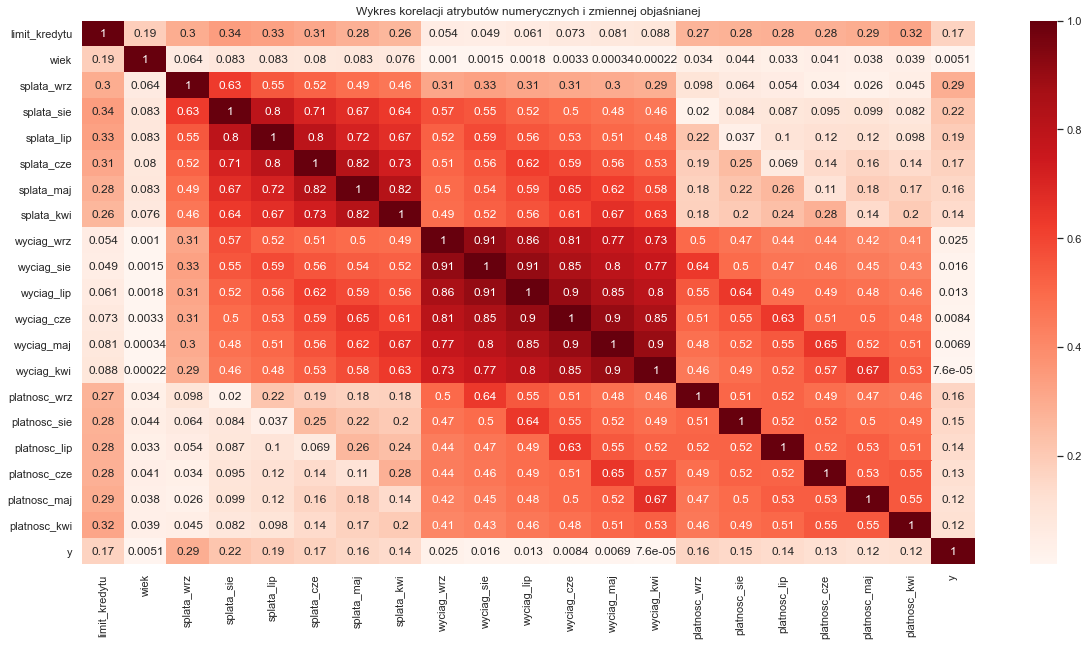

In [18]:
korelacja_num = pd.DataFrame(scipy.stats.spearmanr(df.drop(['plec', 'wyksztalcenie', 'stan_cywilny'], axis = 1))[0],
columns = df.drop(['plec', 'wyksztalcenie', 'stan_cywilny'], axis = 1).columns,
index = df.drop(['plec', 'wyksztalcenie', 'stan_cywilny'], axis = 1).columns) #bez atrybutów kategoryzujących

plt.figure(figsize=(20,10))
sns.set(font_scale=1)
sns.heatmap(korelacja_num.abs(), cmap="Reds", annot=True).set(title='Wykres korelacji atrybutów numerycznych i zmiennej objaśnianej')
plt.show()

Atrybuty z grupy *stan spłaty* są najbardziej skorelowane ze zmienną objaśnianą *y*. Korelacja wzrasta ze zbliżaniem się do października.
*Limit kredytu* i atrybuty z grupy *płatności* są w niewielkim stopniu skorelowane ze zmienną objaśnianą *y*.
*Wiek* i atrybuty z grupy *wyciąg* są tylko nieznacznie skorelowane ze zmienną objaśnianą *y*.
Wydaje się być oczywiste, że wartość wyciągu jest mocno skorelowana z wartością płatności, a w szczególności zależna jest *płatność* w danym miesiącu i *wyciąg* w kolejnym miesiącu.
*Wiek* praktycznie nie ma korelacji z żadnym z atrybutów (niewielka z *limit kredytu*).

<a class="anchor" id="kat_celu"></a>
### Atrybuty kategoryzujące nominalne a zmienna objaśniana

y,0,1
wyksztalcenie,,
inne,116,7
nieznane,319,26
srednie,3680,1237
wyzsze,10700,3330
wyzsze_pelne,8549,2036


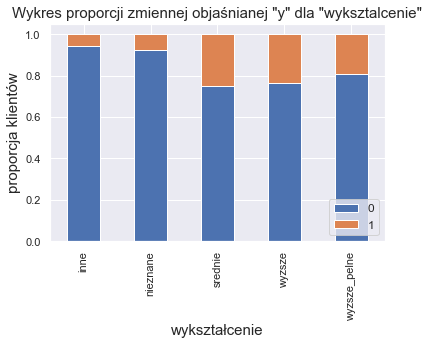

In [19]:
#Wykres proporcji zmiennej objaśnianej "y" dla wykształcenia
wyksz_y=pd.crosstab(df.wyksztalcenie,df.y)
wyksz_y.div(wyksz_y.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

plt.title('Wykres proporcji zmiennej objaśnianej "y" dla "wyksztalcenie"', fontsize=15)
plt.xlabel('wykształcenie', fontsize=15)
plt.ylabel('proporcja klientów', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
wyksz_y

y,0,1
plec,,
kobieta,14349,3763
mezczyzna,9015,2873


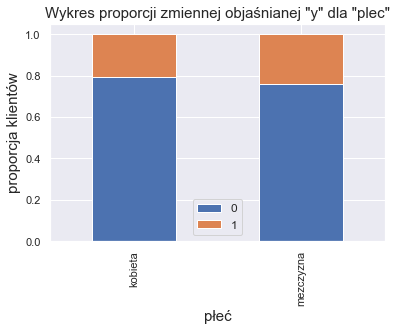

In [20]:
#Wykres proporcji zmiennej objaśnianej "y" dla płci
plec_y=pd.crosstab(df.plec,df.y)
plec_y.div(plec_y.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Wykres proporcji zmiennej objaśnianej "y" dla "plec"', fontsize=15)
plt.xlabel('płeć', fontsize=15)
plt.ylabel('proporcja klientów', fontsize=15)
plt.legend(fontsize=12)
plec_y

y,0,1
stan_cywilny,,
inny,239,84
kawaler_panna,12623,3341
nieznany,49,5
w_zwiazku,10453,3206


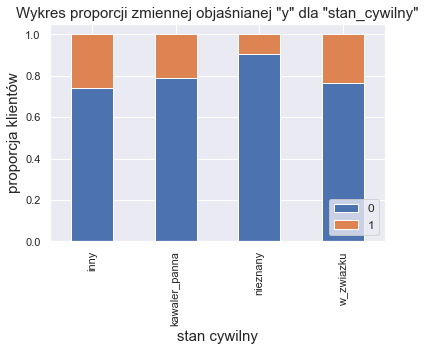

In [21]:
#Wykres proporcji zmiennej objaśnianej "y" dla stanu cywilnego
stan_cyw_y=pd.crosstab(df.stan_cywilny,df.y)
stan_cyw_y.div(stan_cyw_y.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Wykres proporcji zmiennej objaśnianej "y" dla "stan_cywilny"', fontsize=15)
plt.xlabel('stan cywilny',fontsize=15)
plt.ylabel('proporcja klientów',fontsize=15)
plt.legend(loc='lower right', fontsize=12)
stan_cyw_y

Na podstawie powyższych wykresów proporcji występowania klientów wiarygodnych/niewiarygodnych dla poszczególnych atrybutów kategoryzujących można stwierdzić, że zależność pomiędzy atrybutami kategoryzującymi a zmienną objaśniana nie jest duża. Największe zróżnicowanie proporcji występuje dla *wyksztalcenia* (np. dla średniego i wyższego wykształcenia jest duży udział zdarzeń pozytywnych w stosunku do łącznej ilości). Dla *plec* udział "1" dla mężczyzn jest nieznacznie większy niż dla kobiet. Dla *stan_cywilny* *nieznany* jest mniej zdarzeń pozytywnych niż dla pozostałych.

<a class="anchor" id="dodatkowe"></a>
## Dodatkowe analizy
[Powrót do spisu treści](#toc)

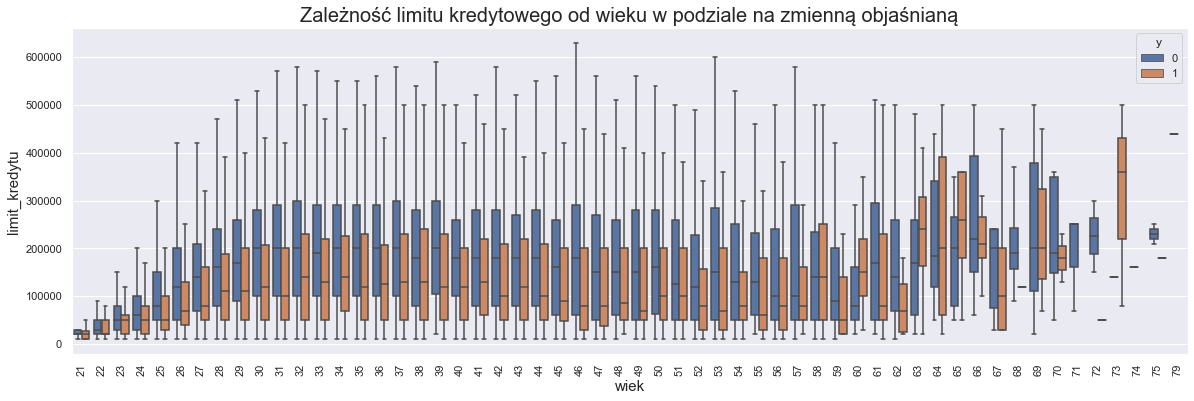

In [22]:
#Zależność limitu kredytowego od wieku w podziale na klienta wiarygodnego[0] / niewiarygodnego[1]
wykres, ax1 = plt.subplots(ncols=1, figsize=(20,6))
s = sns.boxplot(ax = ax1, x='wiek', y='limit_kredytu', hue='y',
                data=df,showfliers=False)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('wiek',fontsize=15)
plt.ylabel('limit_kredytu',fontsize=15)
plt.title('Zależność limitu kredytowego od wieku w podziale na zmienną objaśnianą', fontsize=20)
plt.show()

Na powyższym wykresie widać wzrost limitu kredytowego w zależności od wieku do ok. 30 lat i stabilny poziom aż do wieku 60 lat. W tym okresie dla zdarzeń pozytywnych wartość średniej dla limit kredytowego jest niższa niż dla zdarzeń negatywnych. Po przekroczenie 60 roku większość ludzi przechodzi na emeryturę i zakres przyznanego limitu kredytowego bardziej się wacha i jest mniej stabilny. Po przekroczeniu 70 roku życia jest mało klientów i wyniki są bardziej losowe.

In [23]:
#średnie wartości poszczególnych atrybutów w zależności od wartości zmiennej objaśnianej
df.groupby('y').mean()

,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,wyciag_wrz,wyciag_sie,wyciag_lip,wyciag_cze,wyciag_maj,wyciag_kwi,platnosc_wrz,platnosc_sie,platnosc_lip,platnosc_cze,platnosc_maj,platnosc_kwi
y,,,,,,,,,,,,,,,,,,,,
0,178099.726074,35.417266,-0.211222,-0.301917,-0.316256,-0.355633,-0.389488,-0.405624,51994.227273,49717.435670,47533.365605,43611.165254,40530.445343,39042.268704,6307.337357,6640.465074,5753.496833,5300.529319,5248.220296,5719.371769
1,130109.656420,35.725738,0.668174,0.458258,0.362116,0.254521,0.167872,0.112116,48509.162297,47283.617842,45181.598855,42036.950573,39540.190476,38271.435503,3397.044153,3388.649638,3367.351567,3155.626733,3219.139542,3441.482068


Warto zauważyć, że ogólnie średnia limitu kredytowy, a co za tym idzie średnia wartości wyciągu i płatności w poszczególnych miesiącach jest mniejsza dla klientów oznaczonych jako niewiarygodni {1} w porównaniu do wiarygodnych {0}. To może oznaczać, że klienci niewiarygodni są raczej w grupie osób o mniejszym przyznanym limicie kredytu. Ponadto średnia wartość opóźnienia spłaty zobowiązania dla klientów niewiarygodnych jest dodatnia, a dla wiarygodnych ujemna, co jest w miarę logiczne - kliencie niespłacający zobowiązania w kolejnych miesiącach wkońcu stają się niewiarygodni.


<a class="anchor" id="przygotowanie"></a>
## Przygotowanie danych do modelowania
[Powrót do spisu treści](#toc)

<a class="anchor" id="kodowanie"></a>
### Kodowanie "gorącojedynkowe" atrybutów  kategoryzujących nominalnych


Dla każdego atrybutu, który ma wartości zawierające ciąg znaków została dodana dodatkowa kolumna z wartościami 0 lub 1.

In [24]:
df = pd.get_dummies(df)
df

,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,wyciag_wrz,wyciag_sie,...,plec_mezczyzna,wyksztalcenie_inne,wyksztalcenie_nieznane,wyksztalcenie_srednie,wyksztalcenie_wyzsze,wyksztalcenie_wyzsze_pelne,stan_cywilny_inny,stan_cywilny_kawaler_panna,stan_cywilny_nieznany,stan_cywilny_w_zwiazku
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,0,0,1,0,0,0,0,1
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,0,0,0,1,0,0,1,0,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,0,0,0,1,0,0,1,0,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,0,0,0,1,0,0,0,0,1
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,0,0,0,0,0,0,188948,192815,...,1,0,0,1,0,0,0,0,0,1
29996,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,1,0,0,1,0,0,0,1,0,0
29997,30000,37,4,3,2,-1,0,0,3565,3356,...,1,0,0,0,1,0,0,1,0,0
29998,80000,41,1,-1,0,0,0,-1,-1645,78379,...,1,0,0,1,0,0,0,0,0,1


Z uwagi na możliwość wystąpienia współliniowości (atrybuty po podziale są skorelowane) została usunięta na stałe 1 kategoria atrybutów dla których zostały dodane więcej niż 1 kolumna dodatkowa opisująca kategorię atrybutu czyli dla *stan_cywilny*, *wyksztalcenie*, *plec*. Do usunięcia wybrano kategorię *stan_cywilny_inny*, *wyksztalcenie_inne* i *plec_mezczyzna*.

In [25]:
df.drop(axis = 1, labels = ['stan_cywilny_inny', 'wyksztalcenie_inne', 'plec_mezczyzna'], inplace = True)

<a class="anchor" id="podzial"></a>
### Podział zbioru na uczący i testowy

Dokonano podziału w stosunku: 80% – zbiór uczący, 20% – zbiór testowy.
Dodatkowo dokonano podziału zbioru uczącego na podzbiór uczący (75%) i podzbiór walidacyjny (25%) w celu dokonania sprawdzianu krzyżowego.
Przy podziale uwzględniono żeby wartości zmiennej objaśnianej były równo rozłożone pomiędzy poszczególne zbiory.

In [26]:
y = df.y.copy() #skopiowanie zmiennej objaśnianą "y" przed podziałem
df.drop('y', axis = 1, inplace = True) #usunięcie zmiennej objaśnianej ze zbioru przed podziałem
x_train, x_test, y_train, y_test = train_test_split(sm_api.add_constant(df).rename(columns = {'const':'intercept'}), y, test_size = 0.2, random_state = 1, stratify = y)
x_train, x_vali, y_train, y_vali = train_test_split(x_train, y_train, test_size = 0.25, random_state = 1, stratify = y_train)

In [27]:
x_train.describe()
#x_test.describe()
#x_vali.describe()
#y_train.describe()
#y_test.describe()
#y_vali.describe()

,intercept,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,wyciag_wrz,...,platnosc_maj,platnosc_kwi,plec_kobieta,wyksztalcenie_nieznane,wyksztalcenie_srednie,wyksztalcenie_wyzsze,wyksztalcenie_wyzsze_pelne,stan_cywilny_kawaler_panna,stan_cywilny_nieznany,stan_cywilny_w_zwiazku
count,18000.0,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,1.0,166354.982222,35.407833,-0.018222,-0.134444,-0.166056,-0.224222,-0.265278,-0.288667,50478.378556,...,4822.533833,5066.869222,0.606111,0.012389,0.164778,0.464944,0.354389,0.535333,0.002278,0.451722
std,0.0,128973.119134,9.176817,1.123321,1.200465,1.193410,1.161713,1.123970,1.140891,72850.744069,...,16068.691307,16959.260114,0.488624,0.110617,0.370990,0.498783,0.478341,0.498764,0.047673,0.497678
min,1.0,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3615.500000,...,238.000000,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21788.000000,...,1500.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.0,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65784.000000,...,4003.000000,4000.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.0,1000000.000000,79.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,...,426529.000000,528666.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a class="anchor" id="dobor"></a>
### Dobór atrybutów

Wykonano dobór i zmniejszenie ilości atrybutów w celu zmniejszenia wymiarowości (uniknięcie przetrenowania modelu) przy jednoczesnym niezmniejszeniu skuteczności modelu.

#### Dobór atrybutów metodą lasów losowych

In [28]:
df.columns
atrybuty_lasy =['intercept', 'plec_kobieta', 'wiek', 'splata_wrz',
       'splata_sie', 'splata_lip', 'splata_cze', 'splata_maj', 'splata_kwi',
       'wyciag_wrz', 'wyciag_sie', 'wyciag_lip', 'wyciag_cze', 'wyciag_maj',
       'wyciag_kwi', 'platnosc_wrz', 'platnosc_sie', 'platnosc_lip',
       'platnosc_cze', 'platnosc_maj', 'platnosc_kwi',
       'wyksztalcenie_nieznane', 'wyksztalcenie_srednie',
       'wyksztalcenie_wyzsze', 'wyksztalcenie_wyzsze_pelne',
       'stan_cywilny_kawaler_panna', 'stan_cywilny_nieznany',
       'stan_cywilny_w_zwiazku']
#do badania istotności pominięto atrybut limit_kredytu bo miał bardzo mały poziom istotności który wpływał na działanie algorytmu lasu losowego


 1) splata_sie                     0.100140
 2) splata_wrz                     0.075926
 3) wyciag_sie                     0.064056
 4) wyciag_lip                     0.056422
 5) wyciag_cze                     0.054008
 6) platnosc_sie                   0.053412
 7) platnosc_wrz                   0.052744
 8) wyciag_maj                     0.052549
 9) wyciag_kwi                     0.051775
10) platnosc_lip                   0.050184
11) plec_kobieta                   0.048500
12) platnosc_cze                   0.048273
13) platnosc_maj                   0.047451
14) splata_lip                     0.046398
15) platnosc_kwi                   0.045418
16) splata_cze                     0.029523
17) splata_maj                     0.023136
18) splata_kwi                     0.020708
19) wyciag_wrz                     0.018704
20) wiek                           0.012604
21) wyksztalcenie_wyzsze           0.009814
22) stan_cywilny_kawaler_panna     0.009363
23) stan_cywilny_w_zwiazku      

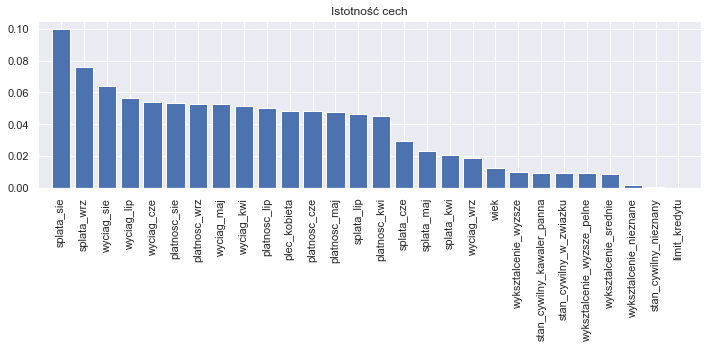

In [29]:
atrybuty = x_train.columns[1:]
forest = RandomForestClassifier(n_estimators=500,random_state=1)
forest.fit(x_train[atrybuty_lasy], y_train)
istotnosc = forest.feature_importances_
indeks = np.argsort(istotnosc)[::-1]

for f in range(x_train[atrybuty_lasy].shape[1]):
    print("%2d) %-*s %f" % (f+1, 30,atrybuty[indeks[f]],istotnosc[indeks[f]]))
 
    
plt.figure(figsize=(10,5))    
plt.title('Istotność cech')
plt.bar(range(x_train[atrybuty_lasy].shape[1]), istotnosc[indeks], align='center')
plt.xticks(range(x_train[atrybuty_lasy].shape[1]), atrybuty[indeks], rotation=90)
plt.xlim([-1, x_train[atrybuty_lasy].shape[1]])
plt.tight_layout()
plt.show()

Na podstawie powyższego wykresu oraz przeprowadzonych testów uzyskiwanych wyników modelowania wybrano atrybuty z poziomem istotności powyżej 0.02.

In [30]:
atrybuty_wybrane=[]
for f in range(x_train[atrybuty_lasy].shape[1]):
    if istotnosc[indeks[f]] > 0.02:
        atrybuty_wybrane.append(atrybuty[indeks[f]])
atrybuty_wybrane.append('intercept')
atrybuty_wybrane

['splata_sie',
 'splata_wrz',
 'wyciag_sie',
 'wyciag_lip',
 'wyciag_cze',
 'platnosc_sie',
 'platnosc_wrz',
 'wyciag_maj',
 'wyciag_kwi',
 'platnosc_lip',
 'plec_kobieta',
 'platnosc_cze',
 'platnosc_maj',
 'splata_lip',
 'platnosc_kwi',
 'splata_cze',
 'splata_maj',
 'splata_kwi',
 'intercept']

<a class="anchor" id="model"></a>
## Model
[Powrót do spisu treści](#toc)

<a class="anchor" id="budowa"></a>
### Budowa modelu

Do wykonania modelu została wykorzystany algorytm regresji logistycznej z biblioteki *statsmodels*.


In [31]:
model = Logit(y_train, x_train[atrybuty_wybrane]).fit(disp = 0) #wykonanie modelu dla danych uczących
y_pred = model.predict(x_vali[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych

<a class="anchor" id="ocena"></a>
### Ocena modelu dla zbioru walidacyjnego

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                18000
Model:                          Logit   Df Residuals:                    17981
Method:                           MLE   Df Model:                           18
Date:                Sun, 14 Feb 2021   Pseudo R-squ.:                  0.1184
Time:                        15:39:47   Log-Likelihood:                -8386.2
converged:                       True   LL-Null:                       -9512.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
splata_sie       0.0897      0.026      3.500      0.000       0.039       0.140
splata_wrz       0.5809      0.023     25.558      0.000       0.536       0.626
wyciag_sie   -2.944e-06   1.26e-06     -2.336      0.020   -5.41e-06   -4.74e-07
wyciag_lip    1.408e-06   1.71e-06      0.822      0.411   -1.95e-06    4.77e-06
wyciag_cze    5.636e-09   1.71e-06      0.003      0.997   -3.35e-06    3.36e-06
platnosc_sie -1.501e-05   3.07e-06     -4.893      0.000    -2.1e-05      -9e-06
platnosc_wrz -1.341e-05   3.08e-06     -4.351      0.000   -1.95e-05   -7.37e-06
wyciag_maj   -6.708e-08   1.96e-06     -0.034      0.973   -3.91e-06    3.78e-06
wyciag_kwi    4.024e-07    1.6e-06      0.252      0.801   -2.73e-06    3.53e-06
platnosc_lip -3.106e-06   2.16e-06     -1.441      0.150   -7.33e-06    1.12e-06
plec_kobieta    -0.1172      0.039     -2.990      0.003      -0.194      -0.040
platnosc_cze -3.317e-06    2.2e-06     -1.507      0.132   -7.63e-06    9.98e-07
platnosc_maj -5.174e-06   2.35e-06     -2.200      0.028   -9.78e-06   -5.65e-07
splata_lip       0.0850      0.029      2.934      0.003       0.028       0.142
platnosc_kwi -2.206e-06   1.72e-06     -1.279      0.201   -5.58e-06    1.17e-06
splata_cze       0.0074      0.032      0.228      0.819      -0.056       0.071
splata_maj       0.0365      0.034      1.063      0.288      -0.031       0.104
splata_kwi       0.0127      0.028      0.451      0.652      -0.042       0.068
intercept       -1.0489      0.036    -29.158      0.000      -1.119      -0.978
================================================================================
"""

Podany powyżej współczynnik coef wskazuje logarytmy szans zajścia niespłacenia kredytu dla poszczególnych atrybutów. Im większe wartości tym większa szansa niespałcenia kredytu. Najwyższy wpływ na niespłacenie kredytu mają atrybuty związane ze stanem spłaty kredytu we wcześniejszych miesiącach, a szczególnie w miesiącu poprzedzającym badany miesiąc (co jest w miarę oczywiste).


In [33]:
fpr, tpr, thresholds = roc_curve(y_vali, y_pred) #wskaźniki modelu
gini = 2 * auc(fpr, tpr) - 1    # współczynnik giniego

print('Pole pod krzywą ROC - AUC: %0.2f' % auc(fpr, tpr))
print('Współczynnik Giniego: %0.2f' % gini)

Pole pod krzywą ROC - AUC: 0.72
Współczynnik Giniego: 0.43


Wartość AUC oraz współczynnika Giniego są akceptowalne, choć ich wartości nie są bardzo duże.

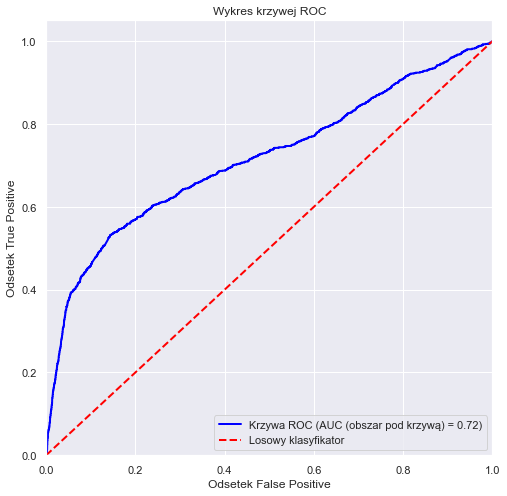

In [34]:
# Krzywa ROC
plt.figure(figsize=(8,8))
lw=2
plt.plot(fpr, tpr, color='blue',lw=lw, label='Krzywa ROC (AUC (obszar pod krzywą) = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label='Losowy klasyfikator')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek False Positive')
plt.ylabel('Odsetek True Positive')
plt.title('Wykres krzywej ROC')
plt.legend(loc="lower right")

plt.show()

Wykres Krzywej ROC jest najbardziej oddalony od lini losowego klasyfikatora w początkowym fragmencie i osiąga maksimum około pierwszej ćwiartki wykresu. Wskazuje to, że szukany optymalny punkt odcięcia (wyznaczony w kolejnym etapie) będzie znajdował się w tym obszarze.

<a class="anchor" id="model_fin"></a>
## Finalna weryfikacja jakości modelu
[Powrót do spisu treści](#toc)

Finalna weryfikacja modelu została przeprowadzona na zbiorze danych testowych, przy uwzględnieniu w modelowaniu  wybranych na wcześniejszym etapie atrybutów.

<a class="anchor" id="budowa_fin"></a>
### Model finalny

In [35]:
model_fin = Logit(y_train, x_train[atrybuty_wybrane]).fit(disp = 0)
y_pred_fin = model_fin.predict(x_test[atrybuty_wybrane])

<a class="anchor" id="ocena_fin"></a>
### Ocena modelu dla zbioru testowego

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_fin) #wskaźniki modelu
gini = 2 * auc(fpr, tpr) - 1 # współczynnik giniego

print('Pole pod krzywą ROC - AUC: %0.2f' % auc(fpr, tpr))
print('Współczynnik Giniego: %0.2f' % gini)

Pole pod krzywą ROC - AUC: 0.72
Współczynnik Giniego: 0.44


Jak widać finalny model klasyfikatora ma prawie identyczne parametry jakości w porównaniu do wartości ze zbioru walidacyjnego i moża je uznać za zadawalające. Wyniki dla zbioru testowego nie odbiegają od wyników dla zbioru walidacyjnego więc model można uznać za nieprzetrenowany i powinien uzyskiwać podobne wyniki na rzeczywistych danych.

<a class="anchor" id="punkt"></a>
### Wyznaczanie optymalnego punktu odcięcia

Założono, że najoptymalniejszy punktu odcięcia będzie odpowiadał maksymalnemu dochodowi banku osiągniętemu dla wyznaczonych ilości klientów którym przyznano kredyt. Zgodnie z założeniami podanymi na początku dochód banku został określony jako:

*dochód =wiarygodni klienci którym przyznano kredyt * zysk - niewiarygodni klienci którym przyznano kredyt * strata*

In [37]:
#założone wielkości zysku i straty
zysk=15
strata=50

In [38]:
punkty_odciecia = np.arange(0, 1.01, 0.01) #punkty odcięcia od 0 do 1 z krokiem co 0.01

#wyznaczenie dochodów dla poszczególnych punktów odcięcia
dochody = {}
for punkt_odciecia in punkty_odciecia:
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fin>punkt_odciecia).ravel()
    dochod = tn * zysk + fn * -strata
    dochody[punkt_odciecia] = dochod
dochody = pd.Series(dochody)

#wyznaczenie maks. dochodu
max_dochod = dochody.iloc[dochody.argmax()]
punkt_odciecia_fin = dochody.iloc[dochody.argmax():dochody.argmax()+1].index[0]
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.'
      .format(max_dochod, punkt_odciecia_fin))


Największy dochód wynosi: 29090, któremu odpowiada punkt odcięcia: 0.25.


<a class="anchor" id="ocena_punkt"></a>
### Ocena klasyfikatora z uwzględnieniem  optymalnego punktu odcięcia

#### Macierz pomyłek i wskaźniki klasyfikacji

|  | Prognozowane "0"  | Prognozowane "1"  
------------ | ------------- | -------------
Prawdziwe "0" | TN | FP
Prawdziwe "1" | FN | TP

Zgodnie z założeniami przy podjęciu określonej decyzji mogą wystąpić następujące sytuacje:
*    True Negative: przyznanie karty kredytowej i spłacanie zadłużenia
*    False Negative: przyznanie karty kredytowej i niespłacanie zadłużenia
*    True Positive: nieprzyznanie karty kredytowej i niespłacanie zadłużenia
*    False Positive: nieprzyznanie karty kredytowej i spłacanie zadłużenia


In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fin>punkt_odciecia_fin).ravel()
dokladnosc = (tn+tp) / (tn+tp+fn+fp)
specyficznosc = tn / (tn+fp)
czulosc = tp / (tp + fn)

macierz_pomylek = pd.DataFrame(confusion_matrix(y_test, y_pred_fin>punkt_odciecia_fin),
                               columns = ['Prognozowane "0"', 'Prognozowane "1"'],
                               index = ['Prawdziwe "0"', 'Prawdziwe "1"'])
print(classification_report(y_test, y_pred_fin>punkt_odciecia_fin))
print('Dokładność: {}'.format(dokladnosc.round(2)))
print('Specyficzność: {}'.format(specyficznosc.round(2)))
print('Czułość: {}'.format(czulosc.round(2)))
print(macierz_pomylek)


              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4673
           1       0.50      0.55      0.52      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000

Dokładność: 0.78
Specyficzność: 0.84
Czułość: 0.55
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              3946               727
Prawdziwe "1"               602               725


Model całkiem dobrze klasyfikuje klientów niewiarygodnych. Dokładność jest dobra (0.78), ale dla sytuacji najgorszej, czyli klientów niewiarygodnych, a sklasyfikowanych jako wiarygodnych, ilość klientów nie jest stosunkowo mała (FN=602). Czułość, która wskazuje udział klientów sklasyfikowanych poprawnie jako niewiarygodnych w ogólnej liczbie klientów niewiarygodnych jest mała (0.55). Prawdopodobnie należałoby jeszcze poprawić dobór parametrów lub zastosować transformacje atrybutów, ale mogłoby to też mieć wpływ na interpretowalność modelu. 

Choć specyficzność jest duża (0.84) to nominalnie model klasyfikuje dużo klientów wiarygodnych jako niewiarygodnych (FP=727), co oznacza niewykorzystanie potencjalnego zysku z wiarygodnych klientów (zgodnie z założeniami nie wzięto tego pod uwagę do oceny rentowności modelu).


<a class="anchor" id="rentownosc"></a>
### Podsumowanie wyników i wyznaczenie rentowności
Rentowność klasyfikatora obliczana jest z uwzględnieniem optymalnego punktu odcięcia

In [40]:
print('Ilość wniosków o wydanie karty kredytowej :', tn + fn + fp + tp)
print('Ilość wydanych kart kredytowych:', tn + fn)
print('Ilość wiarygodnych klientów :', tn)
print('Ilość niewiarygodnych klientów :', fn)

print('Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Ilość wniosków o wydanie karty kredytowej : 6000
Ilość wydanych kart kredytowych: 4548
Ilość wiarygodnych klientów : 3946
Ilość niewiarygodnych klientów : 602
Rentowność: 6.4%


<a class="anchor" id="podsumowanie"></a>
## Podsumowanie i wnioski
[Powrót do spisu treści](#toc)

Na podstawie przeprowadzonej analizy wykonanego modelu można stwierdzić, że wyniki modelu biorąc pod uwagę dochód z całego portfela kredytów jest satysfakcjonujący. Uzyskana rentowność (średni dochód na łączną ilość udzielonych kredytów) jest dobra i wynosi 6.4%. Łączny dochód wyniósł 29090 (gdzie 100 oznacza uśrednioną wartość przyznanego kredytu). 

Dodatkowo należy dodać, że na rzeczywisty wynik bardzo duży wpływ będą miały rzeczywiste wartości zysku i straty. Dla przykładu zmiana zysku z 15% na 10% spowodowałoby, że rentowność zmniejszyłaby się i wyniosłaby 2.17% (dochód =9410). Dodając do tego, że bankowi nie udało by się odzyskać połowy wartości kredytu (źle przeprowadzony proces windykacji) i strata wyniosłaby wtedy 75% to co prawda rentowność wyniosłaby 4.44%, ale dochód byłby na tyle mały (1220), że cała działalność mogłaby być nieopłacalna.

Podsumowując udało się zbudować model który pozwala na wyznaczenie niewypłacalności klienta w przyszłym miesiącu z uwzględnieniem maksymalizowania uzyskanego dochodu przez bank z całego portfela kredytowego. W celu dokładnej oceny jakości modelu należałoby wykonać jeszcze sprawdzenie dodatkowym zestawem danych, który powinien zawierać obserwacje z innego okresu niż obserwacje widoczne w badanym zbiorze danych. 

W celu poprawy wyników możnaby dodatkowo zastosować inny typ algorytmu do zbudowania modelu np. algorytm wzmacniania gradientowego i przeprowadzć weryfikacje osiągniętych wyników. Innymi możliwymi rozszerzeniami są zastosowanie algorymów doboru hiperparametrów i przetransformowanie atrybutów z użyciem np. kategoryzacji atrybutów.
